# Tutorial 3: Scaling Up – Batch Training Deep Networks on HPC

**Course:** CSEN 342: Deep Learning  
**Topic:** HPC Workflows and Deep Feed-Forward Networks

## Objective
In this lab, you will transition from training simple models interactively to submitting computational jobs to a cluster. You will design a Deep Feed-Forward Neural Network to classify images from the **Fashion-MNIST** dataset. 

You will learn to:
1. Define a Multi-Layer Perceptron (MLP) with non-linear activation functions.
2. Write a standalone training script that can run headless on a GPU node.
3. Submit a training job using the Slurm Workload Manager.
4. Analyze training and validation loss curves to identify model convergence.

---

## Part 1: Data Exploration & Model Design (Interactive)

Before we submit a job to the cluster, we must ensure our data loading pipeline works and our model architecture is valid. We will use the **Fashion-MNIST** dataset, which consists of 28x28 grayscale images of 10 fashion categories.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available in the current notebook session
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Notebook session device: {device}")

Notebook session device: cuda


### 1.1 Load and Visualize Data
We define a transform to normalize the image data. Normalization helps the neural network learn faster and more stably.

Sample training images:


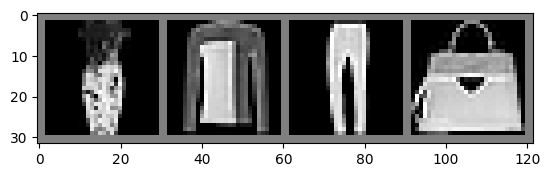

Dress Pullover Trouser Bag  


In [2]:
# Define transformations: Convert to Tensor and Normalize to range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load training data
trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Define classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
print("Sample training images:")
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### 1.2 Define the Neural Network
We will build a network with two hidden layers. We use **ReLU** (Rectified Linear Unit) activation functions to introduce non-linearity.

In [3]:
class FashionMLP(nn.Module):
    def __init__(self):
        super(FashionMLP, self).__init__()
        # Flatten input: 28x28 images -> 784 vector
        self.flatten = nn.Flatten()
        # Hidden Layer 1: 784 inputs -> 512 neurons
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu = nn.ReLU()
        # Hidden Layer 2: 512 inputs -> 256 neurons
        self.fc2 = nn.Linear(512, 256)
        # Output Layer: 256 inputs -> 10 class scores
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# Sanity Check: Instantiate model and pass dummy data
model = FashionMLP()
outputs = model(images)
print("Model architecture verified.")
print("Input shape:", images.shape)
print("Output shape:", outputs.shape) # Should be [4, 10]

Model architecture verified.
Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 10])


---

## Part 2: The HPC Workflow (Batch Submission)

Training deep networks can take hours or days. Instead of keeping this notebook open, we will create a standalone Python script and submit it to the cluster scheduler (Slurm).

### 2.1 Create the Training Script
We use the `%%writefile` magic command to save the code below into a file named `train.py`. This script includes:
1. Device configuration (GPU detection).
2. Data loading.
3. The training loop.
4. **Logging:** It saves training and validation loss to a CSV file so we can plot it later.

In [4]:
%%writefile train.py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import csv
import time

# 1. Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# 2. Hyperparameters & Data
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 15

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load Datasets
full_trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
# Split into Train (50k) and Validation (10k)
train_set, val_set = torch.utils.data.random_split(full_trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 3. Model Definition
class FashionMLP(nn.Module):
    def __init__(self):
        super(FashionMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = FashionMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. Training Loop with CSV Logging
log_filename = 'training_log.csv'
with open(log_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    # Write header
    writer.writerow(['epoch', 'train_loss', 'val_loss', 'val_acc'])

    print("Starting training...")
    start_time = time.time()

    for epoch in range(EPOCHS):
        # Training Phase
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(trainloader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")
        
        # Write stats to CSV
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss, val_acc])

    print(f"Training finished in {time.time() - start_time:.2f} seconds.")

# Save the trained model weights
torch.save(model.state_dict(), 'fashion_mlp.pth')


Overwriting train.py


### 2.2 Create the Slurm Submission Script
Next, we create the shell script that tells the scheduler what resources we need. 
**Note:** We are requesting 1 GPU (`--gres=gpu:1`).

In [5]:
%%writefile submit.sh
#!/bin/bash
#SBATCH --partition=hub                # Partition (queue) name
#SBATCH --job-name=fashion_train
#SBATCH --output=fashion_train_%j.log  # Standard output log
#SBATCH --error=fashion_train_%j.err   # Standard error log
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
## #SBATCH --gres=gpu:1                   # Request 1 GPU (not valid for hub partition, so commented out)
#SBATCH --time=00:15:00                # Time limit
#SBATCH --mem=8G

# Load necessary modules (Uncomment and adjust based on your cluster's specific modules)
module load Anaconda3
conda activate 342wi26

# Execute the python script
python train.py

Overwriting submit.sh


### 2.3 Submit the Job
We use the `sbatch` command to submit the job.

In [9]:
!sbatch submit.sh

Submitted batch job 166134


### 2.4 Monitor Job Status
Run the cell below to check the status of your job. 
* `PD`: Pending (waiting for resources)
* `R`: Running
* `CG`: Completing
* (Empty): Job has finished

Re-run this cell until the job is no longer listed.

In [5]:
!squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


---

## Part 3: Analysis and Visualization

Once the job has finished, it will have created `training_log.csv`. We will load this file to visualize the training process.

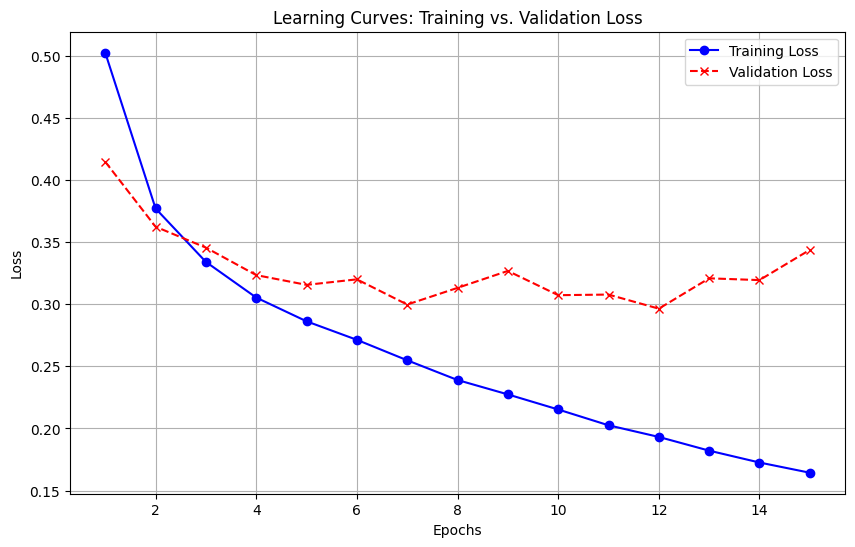

Final Validation Accuracy: 89.32%


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

log_file = 'training_log.csv'

if os.path.exists(log_file):
    # Load the logs generated by the batch job
    df = pd.read_csv(log_file)

    # Create a plot with two lines: Training Loss and Validation Loss
    plt.figure(figsize=(10, 6))
    
    plt.plot(df['epoch'], df['train_loss'], label='Training Loss', marker='o', linestyle='-', color='blue')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='x', linestyle='--', color='red')

    plt.title('Learning Curves: Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Display final accuracy
    print(f"Final Validation Accuracy: {df['val_acc'].iloc[-1]:.2f}%")
else:
    print("Log file not found. The job might still be running or encountered an error.")
    print("Check the .err file generated by Slurm for details.")

### Discussion
1. **Convergence:** Look at the plot. At what epoch does the validation loss stop decreasing? This is arguably where you should stop training to prevent wasted resources.
2. **Overfitting:** Do you see the Training Loss continue to go down while the Validation Loss starts to go up (or flatten out)? If so, your model is starting to memorize the training data rather than generalizing.